In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# from model import *
# from data_loader import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
import numpy as np
from kaldiio import ReadHelper
from sklearn.manifold import TSNE

# Training settings
from Process_Data.constants import cValue_1
from kaldiio import load_mat

matplotlib.rcParams.update({'errorbar.capsize': 5})

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data_dir = '/home/yangwenhao/local/project/SpeakerVerification-pytorch'
sid_length = 7
num_spk = 20

In [3]:

scp_file = data_dir + '/Data/xvector/ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk3_avg5_ASTP2_em256_dp01_alpha0_none1_wd5e4_vares_bashuf/123456/vox1_test_var/test/xvectors.scp'
vects = {}

with open(scp_file, 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        vects[uid] = load_mat(data_dir + '/' + upath)
        
# with ReadHelper('scp:%s'% scp_file) as reader:
#     for key, numpy_array in reader:
#         vects[key] = numpy_array

spks = []
for key in vects:
    s = key[:sid_length]
    if s not in spks:
        spks.append(s)

spks.sort()
spks_this = spks[:num_spk] if len(spks) > num_spk else spks
spk2vec = {}
for s in spks_this:
    spk2vec[s] = []
for key in vects:
    if key[:sid_length] in spks_this:
        this_vec = vects[key]
        vec_len = len(this_vec)
        spk2vec[key[:sid_length]].append(this_vec.reshape(1, vec_len))

all_vectors = []
all_len = [0]
for spk in spk2vec:
    spk_con = np.concatenate(spk2vec[spk])
    all_len.append(len(spk_con))
    all_vectors.append(spk_con)

all_vectors = np.concatenate(all_vectors, axis=0)
S_embedded = TSNE(n_components=2).fit_transform(all_vectors)

emb_group = []
for i in range(len(all_len)-1):
    start = np.sum(all_len[:(i+1)]).astype(np.int32)
    stop = np.sum(all_len[:(i+2)]).astype(np.int32)
    this_points = S_embedded[start:stop]
    assert len(this_points)>0, 'start:stop is %s:%s' %(start, stop)
    emb_group.append(this_points)

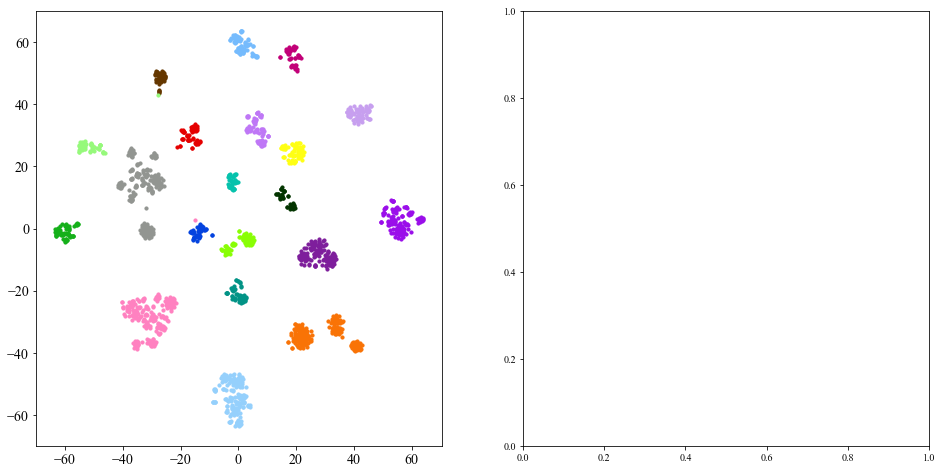

In [4]:
plt.figure(figsize=(16,8))
plt.rc('font', family='Times New Roman')

leng = []
plt.subplot(1,2,1)
for idx, group in enumerate(emb_group) :
    if len(group)>0:
        c = cValue_1[idx]
        leng.append(spks_this[idx])
        plt.scatter(group[:,0], group[:, 1], color=c, s=10)

# plt.legend(leng, loc="best", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
within_vars = []
for spk in spk2vec:
    within_vars.append(np.var(spk2vec[spk], axis=0).sum())


plt.savefig("./tsne.pdf", format="pdf")
plt.show()

In [29]:
within_vars = []
spk2num_utt = []

dist_fn = cos
for spk in spk2vec:
    spk_mean = np.mean(spk2vec[spk], axis=0)
    within_var = 0
    for vec in spk2vec[spk]:
        within_var += dist_fn(vec, spk_mean)**2
    within_var /= len(spk2vec[spk])
    
    # within_var = np.var(spk2vec[spk], axis=0).sum()
    within_vars.append(within_var)
    spk2num_utt.append(len(spk2vec[spk]))

within_var = np.array(within_vars) * np.array(spk2num_utt)
within_var = np.sum(within_var) / np.sum(spk2num_utt)

# between_var = np.var(all_vectors, axis=0).sum() - within_var
overall_mean = np.mean(all_vectors, axis=0)
between_var = 0
for spk in spk2vec:
    # between_var += np.sum((np.mean(spk2vec[spk], axis=0)-overall_mean)**2) * len(spk2vec[spk])
    between_var += dist_fn(np.mean(spk2vec[spk], axis=0), overall_mean)**2 * len(spk2vec[spk])

    
between_var /= np.sum(spk2num_utt)

print("Variance Within-Class Between-Class\n", '         {:>7.4f}    {:>7.4f}'.format(within_var, between_var))
# print(within_var, between_var, np.var(all_vectors, axis=0).sum() - within_var)

# print(within_vars, np.array(spk2vec[spk]).shape, np.array(spk2vec[spk]).var(axis=0).shape)

# np.array(spk2vec[spk]).shape

# l2
# Variance Within-Class Between-Class
#            3.4290     3.6612

Variance Within-Class Between-Class
           0.0835     0.5394


In [43]:
print(within_vars)
print(spk2num_utt)

[3.5222342, 3.6105776, 3.950223, 3.5572858, 3.6057014, 3.367529, 3.4222991, 3.366188, 3.77086, 3.6686451, 3.4042573, 2.808847, 3.0795279, 3.4017825, 3.0772915, 3.5924048, 3.139904, 4.1448555, 3.3980155, 2.8595665]
[140, 71, 49, 240, 50, 71, 185, 64, 185, 61, 62, 81, 84, 233, 84, 91, 148, 48, 46, 83]


In [7]:
# Within-Class Between-Class

# numofspk = 7
baseline = 20.0433/16.5956
input_mixup = 19.1580/12.4805
mani_mixup = 24.7667/16.4467
print(baseline, input_mixup, mani_mixup)


# numofspk = 40
baseline = 19.7768  /  26.2235
input_mixup = 18.9900  /  20.1494
mani_mixup = 24.4632  /  26.5282
print(baseline, input_mixup, mani_mixup)


1.2077478367760128 1.5350346540603343 1.5058765588233507
0.7541632505195721 0.9424598251064547 0.922158307009145


In [23]:
def cos(x,y):
    costh = x*y/(np.sqrt((x**2).sum()) * np.sqrt((y**2).sum()))
    return 1 - costh.sum()


def l2(x, y):
    return np.sqrt(((x-y)**2).sum())

In [24]:
a = np.random.rand(12)
b = np.random.rand(12)
print(cos(a, b), l2(a, b))

0.15320725800778712 1.2769687192846624


In [10]:
a = np.random.rand(12)